# Goodness-of-fit test with Combine
Assuming background model is rejected events (fail VAE cut) miltiplied by some transfer factor (single number or function of dijet invariant mass)

In [1]:
#!pip install mplhep --user -> No part of Conda environment

In [1]:
# Imports
import os, sys
import numpy as np
import ROOT as rt
import uproot
import h5py
import matplotlib.pyplot as plt
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)

Welcome to JupyROOT 6.12/07


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-root_numpy/4.7.3-gnimlf6/lib/python2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.6 is currently installed but you installed root_numpy against numpy 1.14.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/lcg/root/6.12.07-gnimlf5/lib/ROOT.py:318: DeprecationWarning: Python 2 has reached EOL. mplhep is in a deprecated mode. Please switch to Python 3.
  return _orig_ihook( name, *args, **kwds )


In [21]:
#Set the quantile
q = 0.01
SM_eff = q


In [ ]:
#  Get the total, accepted and rejected events for signal and data
path = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/run_111_210202/'

f_qcd = h5py.File(path+'qcd_sqrtshatTeV_13TeV_PU40_reco.h5', 'r')
f_sig = h5py.File(path+'RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV_reco.h5', 'r')

print(f_qcd.keys())
print(list(f_qcd.get("eventFeatureNames")))
print(len(f_qcd.get("eventFeatures")))  

In [38]:
mjj_idx = int(np.where(f_qcd['eventFeatureNames'][()] == 'mJJ')[0])

columns   = {}
columns[0.9]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q90')[0]) # 0=rejected 1=accepted
columns[0.7]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q70')[0])
columns[0.5]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q50')[0])
columns[0.3]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q30')[0])
columns[0.1]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q10')[0])
columns[0.01] = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q01')[0])

# Get all features as numpy arrays
qcd_tot = np.array(f_qcd.get("eventFeatures"))
sig_tot = np.array(f_sig.get("eventFeatures"))

# # Get events which pass the VAE vut
# qcd_acc = qcd_tot[qcd_tot[:,columns[q]] == 1]

# # Get events which are rejected by VAE cut
# qcd_rej = qcd_tot[qcd_tot[:,columns[q]] == 0] 

# # Same for signal
# sig_tot = np.array(f_sig.get("eventFeatures"))
# sig_acc = sig_tot[sig_tot[:,columns[q]] == 1]
# sig_rej = sig_tot[sig_tot[:,columns[q]] == 0] 

# # Use only mjj column (0th column)
# qcd_tot, qcd_acc, qcd_rej = qcd_tot[:,mjj_idx], qcd_acc[:,mjj_idx], qcd_rej[:,mjj_idx]
# sig_tot, sig_acc, sig_rej = sig_tot[:,mjj_idx], sig_acc[:,mjj_idx], sig_rej[:,mjj_idx]

In [78]:
datas_qcd_acc = {}
datas_sig_acc = {}

#Define the main templates using 'the unused quantile 90-100% bacground efficiency
qcd_template = qcd_tot[qcd_tot[:,columns[0.9]] == 0]
qcd_template = qcd_template[:,mjj_idx]
sig_template = sig_tot[sig_tot[:,columns[0.9]] == 0]
sig_template = sig_template[:,mjj_idx]

# Make sure all quantiles are orthogonal (removing events passing q-1 from q distribution)
qcd = np.copy(qcd_tot)
sig = np.copy(sig_tot)

for key in sorted(columns.keys()):
    
    # Start with q=0.01 and take all events that pass cut on VAE
    datas_qcd_acc[key] = qcd[qcd[:,columns[key]] == 1]
    datas_qcd_acc[key] = datas_qcd_acc[key][:,mjj_idx]
    
    datas_sig_acc[key] = sig[sig[:,columns[key]] == 1]
    datas_sig_acc[key] = datas_sig_acc[key][:,mjj_idx]
    
    #Remove those events from dataset and continue to next quantile
    qcd = qcd[qcd[:,columns[key]] == 0]
    sig = sig[sig[:,columns[key]] == 0]


In [79]:
#Define binning
bin_edges = np.array([1200,1246,1313,1383,1455,1530, #bin_edges = np.array([1126,1181,1246,1313,1383,1455,1530,
                      1607,1687,1770,1856,1945,2037,2132,
                      2231,2332,2438,2546,2659,2775,2895,
                      3019,3147,3279,3416,3558,3704,3854,
                      4010,4171,4337,4509,4686,4869,5058,
                      5253,5500,5663,5877,6099,6328,6564,6808]).astype('float')

n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

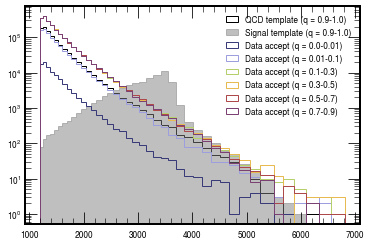

In [80]:
fig, ax = plt.subplots()
colormap = plt.cm.tab20b
mapcolors = [colormap(int(x*colormap.N/len(datas_qcd_acc))) for x in range(len(datas_qcd_acc))]
plt.hist(qcd_template,bins=bin_edges,label='QCD template (q = 0.9-1.0)',histtype='step', linewidth=1, facecolor='none', edgecolor='k',fill=True)
plt.hist(sig_template,bins=bin_edges,label='Signal template (q = 0.9-1.0)',histtype='step', linewidth=1, facecolor='gray', edgecolor='gray', alpha=.5,fill=True)
for i,key in enumerate(sorted(datas_qcd_acc.keys())):
    if i > 0:
        lower_bound = sorted(datas_qcd_acc.keys())[i-1]
    else:
       lower_bound = 0.0 
    plt.hist(datas_qcd_acc[key],bins=bin_edges,label='Data accept (q = {}-{})'.format(lower_bound,key),histtype='step', linewidth=1, facecolor='none', edgecolor=mapcolors[i],fill=True)
    
plt.legend( loc='upper right',frameon=False)
plt.yscale('log')

In [ ]:
# Sanity checks

#Check that sum of orthogonal quantiles yield total
print('N total data events = {}'.format(qcd_tot.shape[0]))
sum_quantiles = 0
for i,key in enumerate(sorted(datas_qcd_acc.keys())):
    sum_quantiles += datas_qcd_acc[key].shape[0]
print('Sum of all events up to 90th quantile = {}'.format(sum_quantiles))
print('Sum of all events between 90th-100th quantiles = {}'.format(qcd_template.shape[0]))
print('N_total - N_1to90 - N_90to100 = {}'.format(qcd_tot.shape[0]-sum_quantiles-qcd_template.shape[0]))

In [ ]:
# # Scale to lumi (! check numbers with Kinga)


# # Values for rescaling the inputs to lumi
# qcd_xsec = 8730000. # Crossection in fb
# qcd_gen_events = 0.75*10e3*1995 # 75% of qcd events are used
# sig_xsec = 1000. # fb
# sig_gen_events = 10e3*99. # all sig events are used
# lumi = 1 # assuming 1/fb

# qcd_tot = qcd_tot*qcd_xsec*lumi/qcd_gen_events
# qcd_acc = qcd_acc*qcd_xsec*lumi/qcd_gen_events
# qcd_rej = qcd_rej*qcd_xsec*lumi/qcd_gen_events
# sig_tot = sig_tot*sig_xsec*lumi/sig_gen_events
# sig_acc = sig_acc*sig_xsec*lumi/sig_gen_events
# sig_rej = sig_rej*sig_xsec*lumi/sig_gen_events

Warning in <TROOT::Append>: Replacing existing TH1: background_rej (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: signal_rej (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


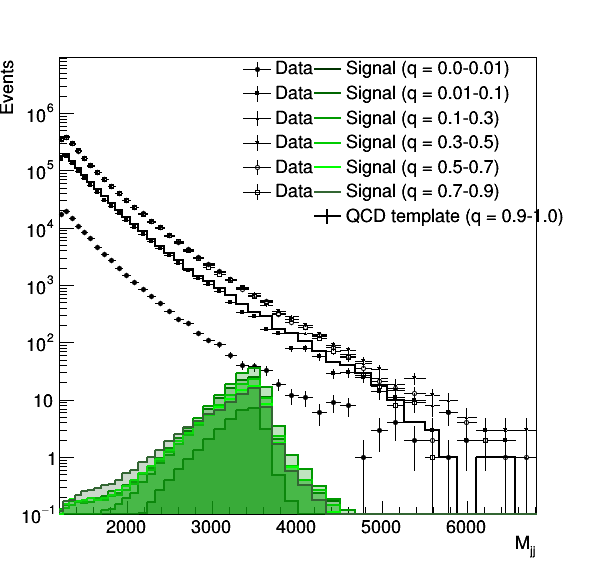

In [111]:
# Fill histograms using dijet binning
axis_title = ['M_{jj}','Events']

background_hist_template = rt.TH1D('background_rej','background_rej',n_bins,bin_edges.astype('float'))
signal_hist_template     = rt.TH1D('signal_rej'    ,'signal_rej'    ,n_bins,bin_edges.astype('float'))
rtnp.fill_hist(background_hist_template, qcd_template, weights=None)
rtnp.fill_hist(signal_hist_template    , sig_template, weights=None)
background_hist_template.SetStats(0)
background_hist_template.Sumw2()
signal_hist_template.SetStats(0)
signal_hist_template.Sumw2()

background_hist_template.SetXTitle(axis_title[0])
background_hist_template.SetYTitle(axis_title[1])
background_hist_template.binning = bin_edges
signal_hist_template.SetXTitle(axis_title[0])
signal_hist_template.SetYTitle(axis_title[1])
signal_hist_template.binning = bin_edges

background_hist_template.SetLineColor(rt.kBlack)
background_hist_template.SetLineColor(rt.kBlack)
background_hist_template.SetLineStyle(rt.kSolid)

signal_hist_template.SetLineColor(rt.kGreen-2)
signal_hist_template.SetLineColor(rt.kGreen-2)
signal_hist_template.SetLineStyle(rt.kSolid)
signal_hist_template.SetLineWidth(2)
background_hist_template.SetLineWidth(2)


leg = rt.TLegend(0.4, 0.6, 0.9, 0.9)
leg.SetNColumns(2)
leg.SetTextSize(0.035)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
# leg.AddEntry(signal_hist_template     , 'Signal template (q = 0.9-1.0)', 'lep')

histos_data = {}
histos_signal = {}

i = 0
for keyD,keyS in zip( sorted(datas_qcd_acc.keys()), sorted(datas_sig_acc.keys()) ):
    histos_data[keyD]  = rt.TH1D('data_obs_{}'.format(keyD),'',n_bins,bin_edges.astype('float'))
    histos_signal[keyS]= rt.TH1D('signal_{}'  .format(keyS),'',n_bins,bin_edges.astype('float'))
    rtnp.fill_hist(histos_data[keyD]   , datas_qcd_acc[keyD], weights=None)
    rtnp.fill_hist(histos_signal[keyS] , datas_sig_acc[keyS], weights=None)
    
    histos_data[keyD]  .SetStats(0)
    histos_signal[keyS].SetStats(0)
    
    histos_data[keyD]  .Sumw2()
    histos_signal[keyS].Sumw2()

    histos_data[keyD].SetXTitle(axis_title[0])
    histos_data[keyD].SetYTitle(axis_title[1])
    histos_data[keyD].binning = bin_edges
    
    histos_signal[keyS].SetXTitle(axis_title[0])
    histos_signal[keyS].SetYTitle(axis_title[1])
    histos_signal[keyS].binning = bin_edges
    
    histos_data[keyD].SetLineColor(rt.kBlack)
    histos_data[keyD].SetLineColor(rt.kBlack)
    
    histos_signal[keyS].SetLineColor(rt.kGreen+4-i)
    histos_signal[keyS].SetLineStyle(rt.kSolid)
    histos_signal[keyS].SetLineWidth(2)
    #histos_signal[keyS].SetFillColor(rt.kGreen+4-i)
    histos_signal[keyS].SetFillColorAlpha((rt.kGreen+4-i), 0.25)

    histos_data[keyD].SetMarkerStyle(20+i)
    histos_data[keyD].SetMarkerSize(0.5)
    i += 1


c = rt.TCanvas('c','c',600,600)

background_hist_template.Draw('HIST')
background_hist_template.SetTitle("")
background_hist_template.SetMinimum(0.1)
background_hist_template.SetMaximum(qcd_tot.shape[0])

# signal_hist_template    .Draw('same HIST')

for i,key in enumerate(sorted(histos_data.keys())):
    if i > 0:
        lower_bound = sorted(histos_data.keys())[i-1]
    else:
       lower_bound = 0.0 
#     leg.AddEntry(histos_data[key], 'Data (q = {}-{})'.format(lower_bound,key), 'lep')
    leg.AddEntry(histos_data[key], 'Data', 'lep')
    leg.AddEntry(histos_signal[key], 'Signal (q = {}-{})'.format(lower_bound,key), 'l')
    histos_data[key].Draw('pez same')
    histos_signal[key].Scale(1/1000.)
    histos_signal[key].Draw('HIST same')
leg.AddEntry(None , '', '') 
leg.AddEntry(background_hist_template , 'QCD template (q = 0.9-1.0)', 'lep')    
c.SetLogy()
c.SetTitle('')

leg.Draw("same")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


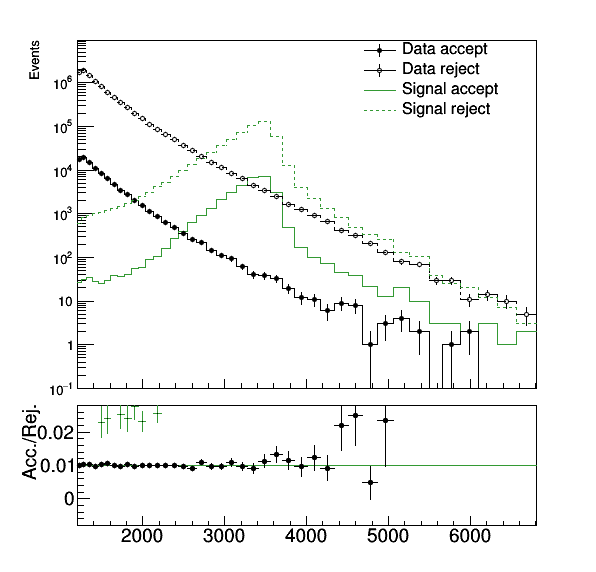

In [85]:
# Do ratio

c_out = rt.TCanvas("ratio", "", 600, 600)
pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.03)
pad1.SetLeftMargin(0.13)
# pad1.SetGridx()
pad1.Draw()
pad1.cd()
background_hist_acc.Draw('HIST')
background_hist_acc.SetTitle("")
background_hist_acc.SetMinimum(0.1)
background_hist_acc.SetMaximum(qcd_rej.shape[0])
background_hist_acc.GetXaxis().SetLabelSize(0)
        
signal_hist_acc    .Draw('same HIST')
data_hist_acc      .Draw('pez same')
background_hist_rej.Draw('same HIST')
signal_hist_rej    .Draw('same HIST')
data_hist_rej      .Draw('pez same')
pad1.SetLogy()
pad1.SetTitle('')

leg = rt.TLegend(0.6, 0.7, 0.9, 0.9)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.AddEntry(data_hist_acc      , 'Data accept', 'lep')
leg.AddEntry(data_hist_rej      , 'Data reject', 'lep')
leg.AddEntry(signal_hist_acc    , 'Signal accept', 'l')
leg.AddEntry(signal_hist_rej    , 'Signal reject', 'l')
leg.Draw("same")
c_out.cd()
pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.03)
pad2.SetBottomMargin(0.27)
pad2.SetLeftMargin(0.13)
# pad2.SetGrid()
pad2.Draw()
pad2.cd()
data_hist_acc.Sumw2()
data_hist_ratio = data_hist_acc.Clone('data_hist_ratio')
data_hist_ratio.SetTitle('')
data_hist_rej.Sumw2()
data_hist_ratio.Divide(data_hist_rej)
data_hist_ratio.binning = bin_edges
# data_hist_ratio.Scale(data_hist_rej.Integral()/data_hist_acc.Integral())
data_hist_ratio.Draw('pez')
data_hist_ratio.SetMaximum(SM_eff+1.8*SM_eff)
data_hist_ratio.SetMinimum(SM_eff-1.8*SM_eff)

data_hist_ratio.SetYTitle('Acc./Rej.')
data_hist_ratio.GetYaxis().SetTitleOffset(0.4)
data_hist_ratio.GetYaxis().SetTitleSize(0.12)
data_hist_ratio.GetYaxis().SetLabelSize(0.12)
data_hist_ratio.GetYaxis().SetNdivisions(506)

data_hist_ratio.GetXaxis().SetNdivisions(506)
data_hist_ratio.GetXaxis().SetTitleOffset(0.95)
data_hist_ratio.GetXaxis().SetTitleSize(0.12)
data_hist_ratio.GetXaxis().SetLabelSize(0.12)
data_hist_ratio.GetXaxis().SetTickSize(0.07)

sig_hist_ratio = signal_hist_acc.Clone('signal_hist_ratio')
sig_hist_ratio.SetTitle('')
sig_hist_ratio.Sumw2()
sig_hist_ratio.Divide(signal_hist_rej)
sig_hist_ratio.binning = bin_edges
# data_hist_ratio.Scale(data_hist_rej.Integral()/data_hist_acc.Integral())


tline = rt.TLine(min_bin, SM_eff, max_bin, SM_eff)
tline.SetLineColor(rt.kGreen-2)
tline.Draw('same')
data_hist_ratio.Draw('pezsame')
sig_hist_ratio.Draw('pez same')
c_out.Draw()

In [20]:
# set up workspace
datacard_ws = rt.TFile.Open('datacard_ws.root','recreate')
w = rt.RooWorkspace('w','w')
x = rt.RooRealVar('x','x',min_bin,max_bin)
w.factory('x[%.1f,%.1f]'%(min_bin, max_bin))

acc_bin_functions = rt.RooArgList()
rej_bin_functions = rt.RooArgList()
w.factory('eff[%f,0,1]'%(background_hist_acc.Integral()/background_hist_rej.Integral()))
w.var('eff').setConstant(True)

empty_hist = rt.TH1D('empty_hist','empty_hist', n_bins, min_bin, max_bin)
epsilon = 0.0000001
for iBinX in range(1,n_bins+1):
    empty_hist.SetBinContent(iBinX,1)
    w.factory('crBin%i_In[%.1f]'%(iBinX,background_hist_rej.GetBinContent(iBinX)))
    w.factory('crBin%i[0,-100,100]'%(iBinX))
    w.var('crBin%i_In'%iBinX).setConstant(True)
    w.var('crBin%i'%iBinX).setConstant(False)
    if background_hist_rej.GetBinContent(iBinX) == 0:
        w.factory("expr::crBin%iFunc('max(0,@0)',crBin%i_In)"%(iBinX,iBinX))
    else:    
        w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,1/rt.TMath.Sqrt(background_hist_rej.GetBinContent(iBinX)),iBinX,iBinX))
    w.factory("expr::bin%iFunc('max(0,@0*@1)',eff,crBin%iFunc)"%(iBinX,iBinX))
    rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
    acc_bin_functions.add(w.function('bin%iFunc'%iBinX))
    
qcd_rph_rej = rt.RooParametricHist('background_rej','background_acc',w.var('x'),rej_bin_functions,empty_hist)
qcd_rph_rej_norm = rt.RooAddition('background_rej_norm','background_rej_norm',rej_bin_functions)
qcd_rph_acc = rt.RooParametricHist('background_acc','background_acc',w.var('x'),acc_bin_functions,empty_hist)
qcd_rph_acc_norm = rt.RooAddition('background_acc_norm','background_acc_norm',acc_bin_functions)
getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())

ds_signal_acc = rt.RooDataHist('signal_acc','signal_acc',rt.RooArgList(w.var('x')),signal_hist_acc)
ds_signal_rej = rt.RooDataHist('signal_rej','signal_rej',rt.RooArgList(w.var('x')),signal_hist_rej)
getattr(w,'import')(ds_signal_acc, rt.RooCmdArg())
getattr(w,'import')(ds_signal_rej, rt.RooCmdArg())


# inject signal
sig_inj_vals = [0, 1, 2, 5, 10, 20, 50] # signal strengths to inject
sig_inj_vals = [0] # signal strengths to inject
for sig_inj in sig_inj_vals:
    data_hist_rej_inj = data_hist_rej.Clone()
    data_hist_acc_inj = data_hist_acc.Clone()
    data_hist_rej_inj.Add(signal_hist_rej,sig_inj)
    data_hist_acc_inj.Add(signal_hist_acc,sig_inj)

    ds_data_acc = rt.RooDataHist('data_obs_inj%i_acc'%sig_inj,'data_obs_inj%i_acc'%sig_inj,rt.RooArgList(w.var('x')),data_hist_acc_inj)
    ds_data_rej = rt.RooDataHist('data_obs_inj%i_rej'%sig_inj,'data_obs_inj%i_rej'%sig_inj,rt.RooArgList(w.var('x')),data_hist_rej_inj)
    getattr(w,'import')(ds_data_acc, rt.RooCmdArg())
    getattr(w,'import')(ds_data_rej, rt.RooCmdArg())

datacard_ws.cd()
w.Write()
datacard_ws.Close()

w.Print('v')

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooParametricHist::background_rej
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooFormulaVar::crBin1Func for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin1_In for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin1 for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooFormulaVar::crBin2Func for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin2_In for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVa

In [9]:
# datacard template
# no background normalization uncertainty

datacard_ratio = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         signal     background
process         0          1
rate            {SIGRATE}    {BKGRATE}
--------------------------------
lumi lnN 1.01 -
eff   flatParam
'''

for i in range(1,n_bins+1):
    datacard_ratio += 'crBin%i   flatParam\n'%i

In [10]:
# write datacard
datacard_ratio_acc = datacard_ratio.format(BIN='acc',
                          OBS=-1,
                          BKGRATE=1,
                          SIGRATE=signal_hist_acc.Integral())
print(datacard_ratio_acc)
with open('datacard_ratio_acc.txt','w') as f:
    f.write(datacard_ratio_acc)
    
    
datacard_ratio_rej = datacard_ratio.format(BIN='rej',
                          OBS=-1,
                          BKGRATE=1,
                          SIGRATE=signal_hist_rej.Integral())
print(datacard_ratio_rej)
with open('datacard_ratio_rej.txt','w') as f:
    f.write(datacard_ratio_rej)


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin acc
observation -1
------------------------------
bin             acc      acc
process         signal     background
process         0          1
rate            31732.0    1
--------------------------------
lumi lnN 1.01 -
eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   flatParam
crBin28   flatParam
crBin29   flatParam
crBin30   flatParam
crBin31   flatParam
crBin32   f

In [11]:
get_ipython().system(u'combineCards.py rej=datacard_ratio_rej.txt acc=datacard_ratio_acc.txt > datacard_ratio.txt')

from subprocess import Popen
import shlex 

for sig_inj in sig_inj_vals:
    # get obseverved goodness of fit test statistic (signal strength = 0)
    get_ipython().system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -n Ratio_inj%i --dataset data_obs_inj%i'%(sig_inj,sig_inj))

    processes = []
    # get expected goodness of fit test statistic distribution from frequentist toys
    for i in range(10):
        command = 'combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -t 200 --toysFreq -n Ratio_inj%i  --dataset data_obs_inj%i -s %i'%(sig_inj,sig_inj,40+i)
        processes.append(Popen(shlex.split(command)))
        #get_ipython().system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -t 100 --toysFreq -n Ratio_inj%i  --dataset data_obs_inj%i -s %i'%(sig_inj,sig_inj,40+i))
    for p in processes:
        p.wait()
    get_ipython().system('hadd -f higgsCombineRatio_inj%i.GoodnessOfFit.mH120.123456.root higgsCombineRatio_inj%i.GoodnessOfFit.mH120.4*.root'%(sig_inj,sig_inj))

 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 123456
Missing variable crBin1 declared as flatParam, will create one!
Warning! -- You haven't picked default values for the Parameters of Interest (either with --expectSignal or --setParameters) for generating toys. Combine will use the 'B-only' ModelConfig to generate, which may lead to undesired behaviour if not using the default Physics Model
RooSimultaneousOpt: number of channel masks must equal number of channels
Done in 0.00 min (cpu), 0.00 min (real)
hadd Target file: higgsCombineRatio_inj0.GoodnessOfFit.mH120.123456.root
hadd compression setting for all ouput: 1
hadd Source file 1: higgsCombineRatio_inj0.GoodnessOfFit.mH120.40.root
hadd Source file 2: higgsCombineRatio_inj0.GoodnessOfFit.mH120.41.root
hadd Source file 3: higgsCombineRatio_inj0.GoodnessOfFit.mH120.42.root
hadd Source file 4: higgsCombineRatio_inj0.Go

Missing variable crBin1 declared as flatParam, will create one!
Warning! -- You haven't picked default values for the Parameters of Interest (either with --expectSignal or --setParameters) for generating toys. Combine will use the 'B-only' ModelConfig to generate, which may lead to undesired behaviour if not using the default Physics Model
RooSimultaneousOpt: number of channel masks must equal number of channels
Done in 0.00 min (cpu), 0.01 min (real)
hadd Target file: higgsCombineRatio_inj20.GoodnessOfFit.mH120.123456.root
hadd compression setting for all ouput: 1
hadd Source file 1: higgsCombineRatio_inj20.GoodnessOfFit.mH120.40.root
hadd Source file 2: higgsCombineRatio_inj20.GoodnessOfFit.mH120.41.root
hadd Source file 3: higgsCombineRatio_inj20.GoodnessOfFit.mH120.42.root
hadd Source file 4: higgsCombineRatio_inj20.GoodnessOfFit.mH120.43.root
hadd Source file 5: higgsCombineRatio_inj20.GoodnessOfFit.mH120.44.root
hadd Source file 6: higgsCombineRatio_inj20.GoodnessOfFit.mH120.45.r

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipython/5.5.0-gnimlf2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipython/5.5.0-gnimlf2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipython/5.5.0-gnimlf2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/python/2.7.14-omkpbe4/lib/python2.7/inspect.py", line 1051, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/python/2.7.14-omkpbe4/lib/python2.7/inspect

IndexError: string index out of range

 <<< Combine >>> 
 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 41
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 40
 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 42
 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 43
 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 44
 <<< Combine >>> 
 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number g

Missing variable crBin1 declared as flatParam, will create one!
Missing variable crBin1 declared as flatParam, will create one!
Missing variable crBin1 declared as flatParam, will create one!
Missing variable crBin1 declared as flatParam, will create one!
Missing variable crBin1 declared as flatParam, will create one!
Missing variable crBin1 declared as flatParam, will create one!
Missing variable crBin1 declared as flatParam, will create one!
Missing variable crBin1 declared as flatParam, will create one!
Missing variable crBin1 declared as flatParam, will create one!
Missing variable crBin1 declared as flatParam, will create one!
Warning! -- You haven't picked default values for the Parameters of Interest (either with --expectSignal or --setParameters) for generating toys. Combine will use the 'B-only' ModelConfig to generate, which may lead to undesired behaviour if not using the default Physics Model
Warning! -- You haven't picked default values for the Parameters of Interest (eith

In [12]:

pvals = []
pvals_fromtoys = []
gofs = []
exp_gofs = []
for sig_inj in sig_inj_vals:
    # open file
    obs_gof_file = uproot.open('higgsCombineRatio_inj%i.GoodnessOfFit.mH120.root'%sig_inj)
    obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

    exp_gof_file = uproot.open('higgsCombineRatio_inj%i.GoodnessOfFit.mH120.123456.root'%sig_inj)
    exp_gof = exp_gof_file['limit'].arrays('limit')['limit']
    exp_gofs.append(exp_gof)
    
    # get p-value from toys
    n_extreme = len(exp_gof[exp_gof > obs_gof])
    n_total = len(exp_gof)
    pval_toys = 1.*n_extreme/n_total
    pvals_fromtoys.append(pval_toys)
    
    # get p-value assuming chi2 dist (may not be valid)
    pval = rt.TMath.Prob(obs_gof,n_bins)
    pvals.append(pval)
    gofs.append(obs_gof)
    print('sig inj = %.1f fb, gof = %.2f, p-value (from chi2) = %.6f, p-value (from toys) = %.6f'%(sig_inj*sig_xsec,obs_gof,pval,pval_toys))
    
plt.figure(figsize=(7,5))
plt.plot(sig_inj_vals,pvals,label='p-value (from chi2)')
plt.plot(sig_inj_vals,pvals_fromtoys,label='p-value (from toys)')
plt.semilogx()
plt.semilogy()
plt.xlabel('signal cross section [fb]')
plt.ylabel('p-value')
plt.legend(loc='lower left')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
sig_inj_vals = [0] # signal strengths to inject
exp_gof = exp_gofs[1]
obs_gof = gofs[1]
pval_toys = pvals_fromtoys[1]
pval = pvals[1]

bin_width = (max(exp_gof+[obs_gof])+np.std(exp_gof)-(min(exp_gof)-np.std(exp_gof)))/30.
exp_gof_hist = rt.TH1D('gof','gof',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
exp_gof_hist_gt = rt.TH1D('gof_gt','gof_gt',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
for g in exp_gof: 
    exp_gof_hist.Fill(g)
    if g > obs_gof: 
        exp_gof_hist_gt.Fill(g)
        
        
d = rt.TCanvas('d','d',500,400)
f = rt.TF1("chi2","%f*ROOT::Math::chisquared_pdf(x,%i,0)"%(exp_gof_hist.Integral()*bin_width,n_bins),min(exp_gof)-np.std(exp_gof),max(exp_gof+[obs_gof])+np.std(exp_gof))
tleg = rt.TLegend(0.48,0.6,0.88,0.7)
tleg.SetLineWidth(0)
exp_gof_hist.Draw('hist')
exp_gof_hist_gt.SetFillColor(rt.kBlue-10)
exp_gof_hist_gt.Draw('fhistsame')
f.Draw('same')
line = rt.TLine(obs_gof,0,obs_gof,exp_gof_hist.GetMaximum())
line.SetLineWidth(2)
line.Draw()
tleg.AddEntry(exp_gof_hist_gt,'p-value (from toys) = %.2f'%pval_toys)
tleg.AddEntry(f,'p-value (from chi2) = %.2f'%pval)
tleg.Draw()
d.Draw()